In [60]:
# Trick: remove versionings and remove AdamW in ./mtl/imports.py

import scanpy as sc
from geneformer import Classifier
import numpy as np
import pybiomart


fname = "ImmuneAtlas"

adata = sc.read_h5ad(f"/home/tomap1/scratch/Olga_Data/{fname}.h5ad")

train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "test": val_ids}

def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl',
                      host='http://www.ensembl.org')
    return dataset

dataset = get_ensembl_mappings()

attributes = ['ensembl_transcript_id', 'mgi_symbol', 
                'ensembl_gene_id', 'ensembl_peptide_id']

response = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

response.index = list(response["Gene name"])
df_unique_index = response[~response.index.duplicated(keep='first')]

rm_genes = adata[:,~adata.var_names.isin(response["Gene name"])].var_names


"""ad = adata[:,adata.var_names.isin(response["Gene name"])]
ad.var["ensembl_id"] = df_unique_index.loc[list(ad.var_names)]["Gene stable ID"]
#list(response.loc[list(ad.var_names)]["Gene stable ID"])

ad.obs["n_counts"] = ad.layers["counts"].sum(axis=1)"""



'ad = adata[:,adata.var_names.isin(response["Gene name"])]\nad.var["ensembl_id"] = df_unique_index.loc[list(ad.var_names)]["Gene stable ID"]\n#list(response.loc[list(ad.var_names)]["Gene stable ID"])\n\nad.obs["n_counts"] = ad.layers["counts"].sum(axis=1)'

In [73]:
adata.write_h5ad("/home/tomap1/scratch/Olga_Data/ImmuneAtlas.h5ad")

In [ ]:
ad = adata[:,adata.var_names.isin(response["Gene name"])]
ad.var["ensembl_id"] = df_unique_index.loc[list(ad.var_names)]["Gene stable ID"]
ad.obs["n_counts"] = ad.layers["counts"].sum(axis=1)
#ad.write_h5ad("/home/tomap1/scratch/ImmuneAtlas/ImmuneAtlas.h5ad")

In [ ]:
#adata.var_names

Index(['ENSG00000241860', 'ENSG00000223764', 'ENSG00000272512',
       'ENSG00000188290', 'ENSG00000187608', 'ENSG00000237330',
       'ENSG00000285812', 'ENSG00000186891', 'ENSG00000186827',
       'ENSG00000169885',
       ...
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198840', 'ENSG00000212907', 'ENSG00000198886',
       'ENSG00000198727', 'ENSG00000277856', 'ENSG00000275063',
       'ENSG00000277836'],
      dtype='object', length=4000)

In [ ]:
#ad.write_h5ad(f"/home/tomap1/scratch/Olga_Data/{fname}.h5ad")

In [69]:
from geneformer import TranscriptomeTokenizer

fname = "ImmuneAtlas"

tk = TranscriptomeTokenizer({"CellType": "CellType", "batchlb": "individual"}, nproc=14,
                            model_input_size=2048)
tk.tokenize_data("/home/tomap1/scratch/ImmuneAtlas",
                 "/home/tomap1/scratch/ImmuneAtlas-geneformer",
                 "test-1",
                 file_format="h5ad",)

Tokenizing /home/tomap1/scratch/ImmuneAtlas/ImmuneAtlas.h5ad


AssertionError: 'ensembl_id' column missing from data.var

In [45]:
cc = Classifier(classifier="cell",
                cell_state_dict={"state_key": "CellType", "states": "all"},
                filter_data=None, # Fine tune on all data types. Example was {"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]},
                nproc=14,
                num_crossval_splits=1,
                training_args = {"num_train_epochs": 0.001,},
                #forward_batch_size=12,
    )

In [55]:
ad.obs.batchlb.unique()

['10x 5' v1', '10x 5' v2', '10x 3' v3']
Categories (3, object): ['10x 3' v3', '10x 5' v1', '10x 5' v2']

In [58]:
train_ids=["10x 5' v1", "10x 3' v3"]
val_ids=["10x 5' v1"]
eval_ids=["10x 5' v2"]
train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": val_ids,
                            "test": eval_ids}


cc.prepare_data(input_data_file="/home/tomap1/scratch/ImmuneAtlas-geneformer/test-1.dataset",
                output_directory="/home/tomap1/scratch/ImmuneAtlas-geneformer",
                output_prefix="test-1",
                split_id_dict=train_test_id_split_dict)

No cells remain after filtering. Check filtering criteria.


RuntimeError: No active exception to reraise

In [23]:
a=list(ad.obs.batchlb.unique())
a.remove("Wang_b4")
a

['Baron_b1', 'Mutaro_b2', 'Segerstolpe_b3', 'Xin_b5']

In [22]:

import scanpy as sc
from geneformer import Classifier
import numpy as np
import pybiomart


fname = "Pancreas"

adata = sc.read_h5ad(f"/home/tomap1/scratch/Olga_Data/{fname}.h5ad")

"""train_test_id_split_dict = {"attr_key": "batchlb",
                            "train": train_ids+eval_ids,
                            "test": test_ids}"""

adata.obs.batchlb.unique()

train_ids=['Baron_b1', 'Mutaro_b2', 'Segerstolpe_b3', 'Wang_b4',]
eval_ids=['Xin_b5']
train_test_id_split_dict = {"attr_key": "batchlb",
                            "train": train_ids,
                            "test": eval_ids}

In [5]:
"""train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": eval_ids,}"""
                            #"test": eval_ids}

all_metrics = cc.validate(model_directory="/home/tomap1/scratch/scAugment/Geneformer/gf-6L-30M-i2048/",
                          prepared_input_data_file="/home/tomap1/scratch/scAugment/geneformer_tmp/test-1_labeled_train.dataset",
                          id_class_dict_file=f"/home/tomap1/scratch/scAugment/geneformer_tmp/test-1_id_class_dict.pkl",
                          output_directory="/home/tomap1/scratch/scAugment/geneformer_tmp",
                          output_prefix="test-1",
                          split_id_dict=train_test_id_split_dict,
                          )

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/tomap1/scratch/scAugment/Geneformer/gf-6L-30M-i2048/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/gpfs/scratchfs01/site/u/tomap1/scAugment/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,No log,2.687273,0.111597,0.042998


  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"/home/tomap1/scratch/scAugment/geneformer_tmp/250330_geneformer_cellClassifier_test-1/ksplit1/",
        id_class_dict_file=f"/home/tomap1/scratch/scAugment/geneformer_tmp/test-1_id_class_dict.pkl",
        test_data_file=f"/home/tomap1/scratch/scAugment/geneformer_tmp/test-1_labeled_test.dataset",
        output_directory="/home/tomap1/scratch/scAugment/geneformer_tmp",
        output_prefix="test-1",
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
#import pandas as pd

all_metrics_test["macro_f1"]
all_metrics_test["acc"]

0.0

In [11]:
from geneformer import EmbExtractor

embex = EmbExtractor(model_type="CellClassifier",
                     num_classes=len(adata.obs.CellType.unique()),
                     #filter_data={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]},
                     #max_ncells=1000,
                     max_ncells=len(ad),
                     emb_layer=-1,
                     emb_label=["individual","CellType"],
                     labels_to_plot=["CellType"],
                     forward_batch_size=200,
                     nproc=16,
                     emb_mode="cell",
                     token_dictionary_file="/home/tomap1/scratch/scAugment/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl") # change from current default dictionary for 30M model series

# extracts embedding from input data
# input data is tokenized rank value encodings generated by Geneformer tokenizer (see tokenizing_scRNAseq_data.ipynb)
# example dataset for 30M model series: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
embs = embex.extract_embs("/home/tomap1/scratch/scAugment/geneformer_tmp/250331_geneformer_cellClassifier_test-1/ksplit1", # example 30M fine-tuned model
                          "/home/tomap1/scratch/Pancreas-geneformer/test-1.dataset",
                          "/home/tomap1/scratch/scAugment/geneformer_tmp",
                          "test-1")


  0%|          | 0/74 [00:00<?, ?it/s]

In [12]:
embs

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,individual,CellType
0,-0.027351,0.164846,0.109781,-0.030246,-0.077342,0.242131,0.101060,0.046862,0.036273,-0.042315,...,-0.048882,0.030493,-0.017545,0.069055,-0.012609,0.052681,0.060440,-0.175269,Mutaro_b2,beta
1,-0.045665,0.194596,-0.020964,-0.039284,-0.069502,0.188238,0.141646,0.049987,0.067823,-0.034469,...,-0.043558,0.014995,0.014956,0.111223,0.035422,0.051076,0.046858,-0.170136,Mutaro_b2,alpha
2,-0.023128,0.174511,0.022583,-0.010508,-0.104726,0.183147,0.035350,0.052799,0.061429,-0.098120,...,-0.098212,0.072188,0.006680,0.066326,0.007100,0.070063,0.032986,-0.141200,Mutaro_b2,acinar
3,-0.010218,0.188116,0.119023,-0.022702,-0.086099,0.220649,0.097494,0.046590,0.023572,-0.030970,...,-0.048027,0.019481,0.002557,0.087611,-0.005230,0.054810,0.069700,-0.173606,Mutaro_b2,alpha
4,-0.024127,0.163963,-0.029198,-0.025354,-0.101734,0.186216,0.065756,0.037016,0.045637,-0.117661,...,-0.076499,0.072770,-0.027235,0.079891,-0.006108,0.105620,-0.046684,-0.144422,Mutaro_b2,acinar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14762,-0.042172,0.133607,-0.154736,0.028876,0.026289,0.063144,-0.015387,0.018714,0.017927,-0.070234,...,-0.087325,0.086234,-0.014946,0.005559,0.008932,-0.002603,-0.070724,0.022165,Baron_b1,beta
14763,-0.019520,0.130293,-0.063724,-0.030033,0.025680,0.127470,0.024106,0.024318,-0.059895,-0.044770,...,-0.078074,0.098394,0.028411,0.041143,-0.013289,0.044519,-0.046499,-0.069252,Baron_b1,beta
14764,-0.003385,0.163798,-0.135590,0.011500,0.039382,0.081527,0.014597,0.022888,-0.031781,-0.052934,...,-0.076297,0.108886,-0.008356,0.034189,-0.009237,0.023090,-0.094872,-0.070142,Baron_b1,alpha
14765,0.021284,0.156578,-0.047072,-0.005082,-0.018362,0.135337,0.063893,0.021252,-0.050194,-0.034727,...,-0.040758,0.095019,-0.034085,0.021226,0.007279,-0.009021,-0.024062,-0.099617,Baron_b1,beta


/scratch/site/u/tomap1/conda/envs/enformer/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/scratch/site/u/tomap1/conda/envs/enformer/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


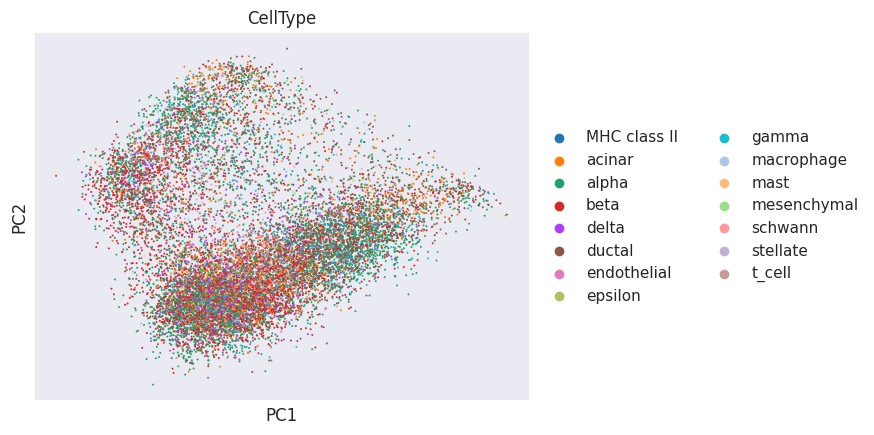

In [13]:


dd=sc.AnnData(embs.drop(columns=["individual", "CellType"]))
dd.obs["CellType"] = list(embs["CellType"])
sc.pp.pca(dd)
sc.pl.pca(dd, color="CellType")

AnnData object with n_obs × n_vars = 14767 × 3838
    obs: 'batch', 'batchlb', 'celltype_orig', 'cellname', 'celltype', 'CellType', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'ensembl_id'
    uns: 'hvg', 'log1p'
    layers: 'counts'